In [1]:
base_model = "./model/skt__kogpt2-base-v2/output_3_PPO"
aug_model =  "./model/skt__kogpt2-base-v2__data-add/output_3_PPO"
ch_model = "./model/skt__ko-gpt-trinity-1.2B-v0.5/output_3_PPO"

### 테스트 데이터셋 만들기

In [5]:
import json 
data_path_1_SFT = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict)) # 12000
list_data_dict[:3]

12000


[{'prompt': '불고기용 고기 한우에요?',
  'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
  'tokens': 193},
 {'prompt': '쓰던 앱이 유료로 전환됐어',
  'completion': "'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다.",
  'tokens': 288},
 {'prompt': '여친이랑 다툼',
  'completion': "'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하지만 다투게 되면 상대방의 말을 경청하는 태도와 서로의 감정을 존중하는 것이 중요합니다. 논리적이고 차분한 대화를 통해 문제를 해결해보세요. 그리고 서로를 이해하고 서로의 의견을 수용하는 것이 중요합니다.",
  'tokens': 153}]

In [6]:
list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

In [11]:
list_answer = list(filter(lambda obj: obj["prompt"] in list_prompt, list_data_dict))

In [12]:
list_answer

[{'prompt': '불고기용 고기 한우에요?',
  'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
  'tokens': 193},
 {'prompt': '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
  'completion': "'1953년입니다.",
  'tokens': 44},
 {'prompt': '오늘 미세먼지 어때?',
  'completion': "'미세먼지 농도는 어제와 비교해서 개선되었지만 아직도 나쁜 수준이며, 마스크 착용과 실외 활동 자제를 권장합니다. 정확한 미세먼지 농도를 확인하려면 해당 지역의 미세먼지 측정소에서 확인해보시기 바랍니다.",
  'tokens': 140}]

In [13]:
list_answer = list(map(lambda obj: obj["completion"], list_answer))
list_answer

["'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
 "'1953년입니다.",
 "'미세먼지 농도는 어제와 비교해서 개선되었지만 아직도 나쁜 수준이며, 마스크 착용과 실외 활동 자제를 권장합니다. 정확한 미세먼지 농도를 확인하려면 해당 지역의 미세먼지 측정소에서 확인해보시기 바랍니다."]

### 필요한 library import

In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

### 토크나이저 로딩

In [15]:
tokenizer = AutoTokenizer.from_pretrained(
    "skt/kogpt2-base-v2", bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


In [16]:
ch_tokenizer = AutoTokenizer.from_pretrained(
    "skt/ko-gpt-trinity-1.2B-v0.5", bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(ch_tokenizer)

GPT2TokenizerFast(name_or_path='skt/ko-gpt-trinity-1.2B-v0.5', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True)


### text 생성 및 육안으로 확인

In [22]:
def generate_text(save_dir, tokenizer):
    generator = pipeline('text-generation', model=save_dir, tokenizer=tokenizer)

    generation_args = dict(   
        num_beams=4,
        repetition_penalty=2.0,
        no_repeat_ngram_size=4,
        eos_token_id=375, # \n   
        max_new_tokens=64,
        do_sample=True,
        top_k=50,
        early_stopping=True
    )

    PROMPT_DICT = {
        "prompt_input": (
            "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
        )
    }

    list_prompt = ['불고기용 고기 한우에요?',
                   '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
                   '오늘 미세먼지 어때?',
                   '시카고 오헤어 국제공항은 어디에 있어?']

    list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

    list_result = generator(list_prompt, **generation_args)   
    list_answer = []
    for prompt, result in zip(list_prompt, list_result):
        print()
        answer = result[0]['generated_text']
        print(answer)
        list_answer.append(answer)
    return list_answer

In [23]:
base_answers = generate_text(base_model, tokenizer)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 일반적으로 불고기용 고기는 쇠고기에 비해 상대적으로 가격이 저렴하고 맛도 좋은 경우가 많습니다. 따라서 해당 가게의 메뉴를 확인해보시는 것이 좋을 것 같습니다. 감사합니다.英書: "불고기용 고

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 47대 부통령직을 수행하지 않았습니다. 따라서 정확한 답변을 제공할 수 없습니다. 그러나 리처드 닉슨은 39대 부통령직을 수행하는 동안 여러 가지 이유로 인해 사망하였습니다. 그는 1994년에 부통령직에서 물러났습니다.英譯)은 "리처드 닉슨"의 줄임말입니다.英譯은

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'저는 인공지능 어시스턴트이기 때문에 미세먼지 여부에 대한 정보를 알 수 없습니다. 하지만 미세먼지 예보를 확인해 보시는 것이 좋을 것 같습니다. 미세먼지가 심한 날에는 실외활동을 자제하고, 대중교통을 이용하시는 것이 좋습니다. 또한, 미세먼지 노출이 심한 날에는

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):'시카고 오 헤어 국제공항은 미국 캘리포니아주 샌프란시스코에 위치해 있습니다. 이 국제공항은 미국 전역의 국제공항을 운영하고 있으며, 공항의 운영시간은 지역에 따라 다를 수 있습니다. 따라서 해당 공항의 운영시간을 확인하려면 해당 공항의 공식 웹사이트나 고객센터에 문의하시는 것이 좋을 것 같습니다.英書:


In [24]:
aug_answers = generate_text(aug_model, tokenizer)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):저는 인공지능 언어모델로써 답변을 제공하며, 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 부위를 사용합니다. 따라서 질문이 명확하지 않아 정확한 답변을 제공할 수 없습니다. 양해 부탁드립니다.\n\n감사합니다.\nI can together th

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):리처드 닉슨은 41대 부통령직을 수행 년도는 1952년입니다.\n\n1953년, 리처드 닉슨은 47대 부통령을 역임하였습니다.\n- 1949년, 리처드 닉슨: 47대 부통령으로 재임했습니다.\n위와 같은 정보는 제공되지 않았습니다.原

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):미세먼지 저는 인공지능 어시스턴트이기 때문에 미세먼지 정보를 알 수 없습니다. 따라서 해당 정보를 제공할 수 없습니다. 죄송합니다. 따라서, 미세먼지 관련 정보를 얻기 위해서는 해당 지역의 미세먼지 측정소에서 확인하시는 것이 좋습니다. 감사합니다. 북부지방 미세먼지

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):시카고 오 헤어 국제공항은 미국 일리노이 주 시카고에 위치해 있습니다.高)高)은 미국 일리노이 주 시카고에서 출발하여 워싱턴 D.C.에 도착하는 항공편입니다.高)는 미국에서 가장 인기 있는 국제공항 중 하나입니다.高는 미국 일리노이 주의 시카고에서 출발하여 샌프란시스코와 뉴욕으로 가는 항공편입니


In [25]:
ch_answers = generate_text(ch_model, ch_tokenizer)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 AI 어시스턴트이기 때문에 이 문장에 대한 정확한 답변을 제공할 수 없습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. \n\n따라서, 이 문장이 어떤 맥락에서 사용되는지 더 자세한 정보를 제공해주시면 보다 정확한

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'1953년입니다. (출처: The Report of the United States Department of the National Association. ) 리처드 닉슨은 1953년에 43대 부통령으로 선출되었습니다. (Context:

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'저는 인공지능 챗봇이므로 미세먼지 농도에 대한 정보를 알 수 없습니다. 하지만 일반적으로 미세먼지 농도는 지역, 국가 및 계절에 따라 다를 수 있습니다. 따라서 해당 지역의 미세먼지 농도를 확인해보시는 것이 좋을 것 같습니다. \n\n하지만 만약 미세먼지 농도가 심각하다면 마스크 착용과 같은 예방 조치를 취

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):'시카고오헤어국제공항은 미국 일리노이주 시카고에 위치해 있습니다. (출처: 시카고 교통국 웹사이트) 시카고 공항의 위치는 다음과 같습니다.\n\n- 주소: Seattle Airport, Chicago, Ill


셋 다 비슷하게 오류가 있는것 같은데 데이터셋에 없는 시카고 오헤어 국제 공항의 위치는 확실히 파운데이션모델을 더 큰모델로 교체했을때 결과가 좋아진 것 같다.

In [28]:
ch_answers = list(map(lambda x: x.split('### Response(응답):')[1], ch_answers))

In [30]:
aug_answers = list(map(lambda x: x.split('### Response(응답):')[1], aug_answers))

In [31]:
base_answers = list(map(lambda x: x.split('### Response(응답):')[1], base_answers))

In [32]:
ch_answers = ch_answers[:-1]
aug_ansers = aug_answers[:-1]
base_answers = base_answers[:-1]

### blue score 측정하기

In [33]:
from konlpy.tag import Mecab
from nltk.translate.bleu_score import sentence_bleu

mecab = Mecab()

In [38]:
def bleu_score(reference, candidate):
    reference = mecab.morphs(reference)
    candidate = mecab.morphs(candidate)
    return sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)) # 2-gram부터 없어서 1-gram 사용

In [40]:
def get_bleu_score(answers):
    scores = []
    for reference, candidate in zip(list_answer, answers):
        scores.append(bleu_score(reference, candidate))
    return scores

In [41]:
ch_scores = get_bleu_score(ch_answers)
aug_scores = get_bleu_score(aug_answers)
base_scores = get_bleu_score(base_answers)

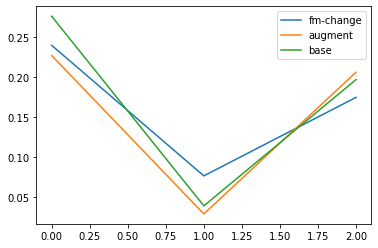

In [48]:
import matplotlib.pyplot as plt
index = list(range(3))
plt.plot(ch_scores, label="fm-change")
plt.plot(aug_scores, label="augment")
plt.plot(base_scores, label = "base")
plt.legend()

2-gram부터 등장하지 않아서 1-gram을 사용했기 때문에 큰의미는 없을것 같다. 시간이 있어서 다른 지표를 알아봤으면 좋았을듯하다.